# Smartseq3 Data Analysis

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import interpn
from scipy import stats
import matplotlib.pyplot as plt
from pathlib2 import Path
import os
import pickle
import mygene

# Load Datasets

Choose the dataset you want to analyze between Hek cells and Fibroblasts. In this example is reported the fibroblasts analysis.

Data names:

'fibroblasts'

'hek_cells'

In [3]:
data_names=['fibroblasts', 'hek_cells']
data_name= data_names[0]
data = pd.read_csv('/Smartseq3.{}.txt'.format(data_name), sep='\t')

# Separate Coding From Non Coding

in our analisys we only considered coding genes. Use the following to get the coding genes data matrix. You can run it just once saving annotation and the resulting data matrix. It may takes a while.

In [5]:
def get_coding_genes(data, data_name,save=True):
    genes= list(data.index)
    mg = mygene.MyGeneInfo()
    output=mg.getgenes(genes)
    gene_annotation=pd.DataFrame()

    genes_=np.array(genes)
    output_=pd.DataFrame(output)

    output_genes=np.array(pd.DataFrame(output)['query'])
    info=[]
    for idx,i in enumerate(range(genes_.shape[0])):
        if genes_[idx]==output_genes[idx]:
            info.append(output_['type_of_gene'][idx])
        else:
            right_idx=np.argwhere(output_genes==genes_[idx])[0][0]
            info.append(output_['type_of_gene'][right_idx])
    gene_annotation=pd.DataFrame(info)

    gene_annotation=gene_annotation.T
    if save:
        gene_annotation.to_csv('{}_gene_annotation_umi.csv'.format(data_name))

    gene_annotation_umi=gene_annotation.T

    coding_idx = gene_annotation_umi[gene_annotation_umi.values=='protein-coding'].index
    noncoding_idx = gene_annotation_umi[gene_annotation_umi.values!='protein-coding'].index
    coding_data=data.iloc[coding_idx]
    noncoding_data=data.iloc[noncoding_idx]
    if save:
        coding_data.to_csv('{}_coding_genes.csv'.format(data_name))  
        noncoding_data.to_csv('{}_noncoding_genes.csv'.format(data_name)) 
    return coding_data, noncoding_data

df, noncoding_df=get_coding_genes(data, data_name, save=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20697...done.


# Sampling Model

Now let's generate random sampling data to compare to the empirical ones. 

In [17]:
def sampling_data(data, data_name, save):
    rs = np.random.RandomState(seed=42)
    mean=np.mean(data, axis=1)
    n_genes=data.shape[0]
    n_cells=data.shape[1]
    fake_organ=np.zeros((data.shape)).astype('float32')
    R = data.shape[1]
    f = 1./R * ((data/data.sum(axis=0)).sum(axis=1))
    for i in range(n_cells):
        fake_col=np.mean(np.random.multinomial(int(np.sum(data,axis=0)[i]), f, size=1),axis=0)               
        fake_organ[:,i]= np.array(fake_col)
    fake_organ= pd.DataFrame(fake_organ.reshape((n_genes,n_cells))).set_index(df.index)
    fake_organ.columns=data.columns
    if save==True:
        fake_organ.to_csv('{}_sampling.csv'.format(data_name)) 
    return fake_organ

df_sampling=sampling_data(df, data_name, save=False)

# Get Data Main Table

It takes a while..

In [25]:
def return_data_matrix(data,data_name,save=True):
    df_=pd.DataFrame()
    R = data.shape[1]
    occ = np.zeros(data.shape[0])
    sampling_occ = np.zeros(data.shape[0])
    sampling_occ_var = np.zeros(data.shape[0])
    notzerosdata=(data>0).sum(axis=1)
    notzerossampling_matrix=np.zeros((data.shape[0],200))
    sparsity=np.zeros((200))
    for i in range(200):
        sampling_data_=sampling_data(data, '{}_sampling.csv'.format(data_name), save=False)
        notzerossampling=(sampling_data_>0).sum(axis=1)
        notzerossampling_matrix[:,i]=notzerossampling
        sparsity[i]=(sampling_data_==0).sum().sum()/(sampling_data_.shape[0]*sampling_data_.shape[1])
    notzerossampling_mean=notzerossampling_matrix.mean(axis=1)
    notzerossampling_var=np.sqrt(notzerossampling_matrix.var(axis=1))
    cells_num=data.shape[1]
    mean_sparsity=sparsity.mean()
    
    inf_idx = np.argwhere(notzerossampling_mean!=0)
    inf_idx=inf_idx.reshape(inf_idx.shape[0])
    
    inf_idx_data = np.argwhere(notzerosdata.values!=0)
    inf_idx_data =inf_idx_data.reshape(inf_idx_data.shape[0])
    
    occ[inf_idx_data] = notzerosdata[inf_idx_data].astype(float)/cells_num
    sampling_occ[inf_idx] = notzerossampling_mean[inf_idx].astype(float)/cells_num
    sampling_occ_var[inf_idx] = notzerossampling_var[inf_idx].astype(float)/cells_num
    
    df_['gene_name']=data.index
    df_['f']=1./R * ((data/data.sum(axis=0)).sum(axis=1))
    df_['real_occ']=occ
    df_['pred_occ']=sampling_occ
    df_['opred-oreal']=df_['pred_occ']-df_['real_occ']
    df_['occ_var']=sampling_occ_var
    df_[df_['occ_var']>10000]=0
    if save==True:
        df_.to_csv('{}_MainTable.csv'.format(data_name))
    print('The sparsity of the sampling data matrix is: ', mean_sparsity, '+/- ', np.sqrt(sparsity.var()))
    return df_, sparsity, mean_sparsity, notzerossampling_matrix

df_mainTable, sparsity_matrix, mean_sparsity, notzerossampling_matrix =return_data_matrix(df,data_name)

The sparsity of the sampling data matrix is:  0.48944241119088405 +/-  0.00012898753711036346


<ipython-input-25-5cc88be5be4e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['opred-oreal']=df_['pred_occ']-df_['real_occ']


In [29]:
gene_name=df_mainTable['gene_name']
real_occ=df_mainTable['real_occ']
pred_occ=df_mainTable['pred_occ']
opred_oreal=pred_occ-real_occ
occ_var=df_mainTable['occ_var']

# Data info and Zeros Percentage

In [30]:
print('Data shape (genes, cells): ', data.shape)
print('Coding genes: ', df.shape[0])
print('Non-coding genes: ', noncoding_df.shape[0])

Data shape (genes, cells):  (20697, 369)
Coding genes:  14734
Non-coding genes:  5963


In [31]:
print('Percentage of zeros: ', (df==0).sum().sum()/(df.shape[0]*df.shape[1]))

Percentage of zeros:  0.5719782154898213


# Select genes with $o_i$,pred - $o_i$,real > $\theta$

In [65]:
theta = 0.4
opred_oreal=pd.DataFrame(opred_oreal).set_index(df.index)
overlist_genes = opred_oreal[opred_oreal> theta].index

Index(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000037',
       'ENSMUSG00000000049', 'ENSMUSG00000000056', 'ENSMUSG00000000058',
       'ENSMUSG00000000078', 'ENSMUSG00000000085', 'ENSMUSG00000000088',
       'ENSMUSG00000000093',
       ...
       'ENSMUSG00000113949', 'ENSMUSG00000114212', 'ENSMUSG00000114279',
       'ENSMUSG00000114456', 'ENSMUSG00000114481', 'ENSMUSG00000114943',
       'ENSMUSG00000115219', 'ENSMUSG00000115293', 'ENSMUSG00000115338',
       'ENSMUSG00000115611'],
      dtype='object', length=14734)

# Define Plot Parameters

In [32]:
save=False
folder_name='img_{}'.format(data_name)
if save==True:
    if not Path('{}'.format(folder_name)).exists():
        Path('{}'.format(folder_name)).mkdir()
fontsize_written=45
fontsize_ticks=40
fontsize_legend=50
lw=15
ms=25
s_size=(18,15)

# Fig.8A and S9A
## Rank Plot

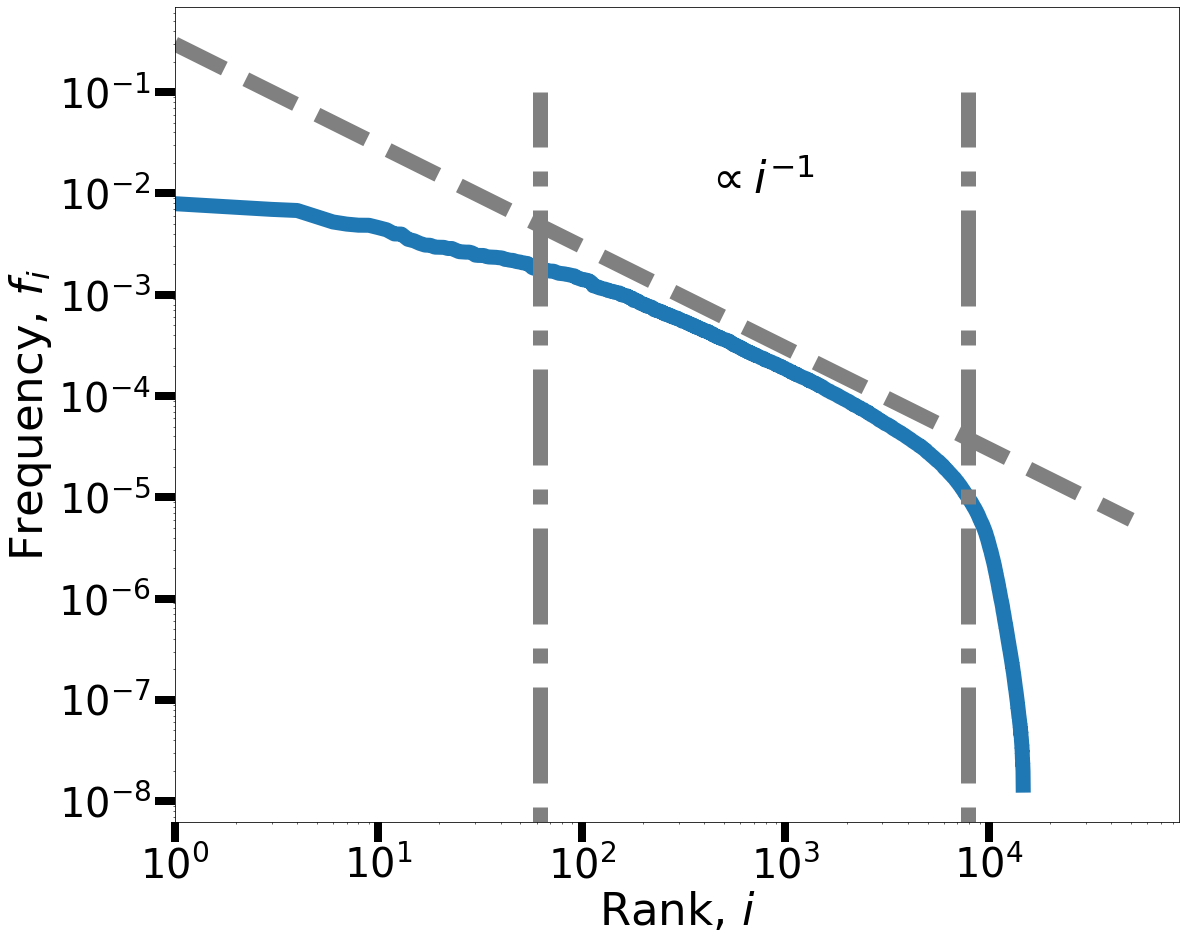

In [33]:
# Zipf classic e 3 regimi
def rank_plot(data,title, save=False):
    def func(x, a,b):
        return b/(x**a)
    R = data.shape[1]
    f = 1./R * (data/data.sum(axis=0)).sum(axis=1)
    plt.figure(figsize=s_size)
    plt.plot(np.arange(data.shape[0]),np.sort(f)[::-1],'-', lw=lw)
    x=np.linspace(1,5*10**4,num=10000)
    plt.plot(x, func(x,1,0.3),'--', lw=lw, color='gray')
    plt.annotate("$\propto i^{-1}$",xy=(10000,0.1) ,xytext=(400,0.01), fontsize=fontsize_written, color='black') 
    x=np.linspace(1,5*10**4,num=10000)
    plt.plot(np.repeat(62,1000), np.linspace(0,0.1,1000), '-.',color='gray',lw=lw)
    plt.plot(np.repeat(7900,1000), np.linspace(0,0.1,1000), '-.',color='gray',lw=lw)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank, $i$', fontsize=fontsize_written)
    plt.ylabel('Frequency, $f_i$', fontsize=fontsize_written)
    plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
    plt.xlim(left=1)
    #plt.title('{}'.format(title))
    if save==True:
        plt.savefig('{}/{}.pdf'.format(folder_name,title),bbox_inches='tight')
rank_plot(df,'{}_Zipf_regimes'.format(data_name))

# Figs.8B and S9B
## Heaps 

/home/silvia/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


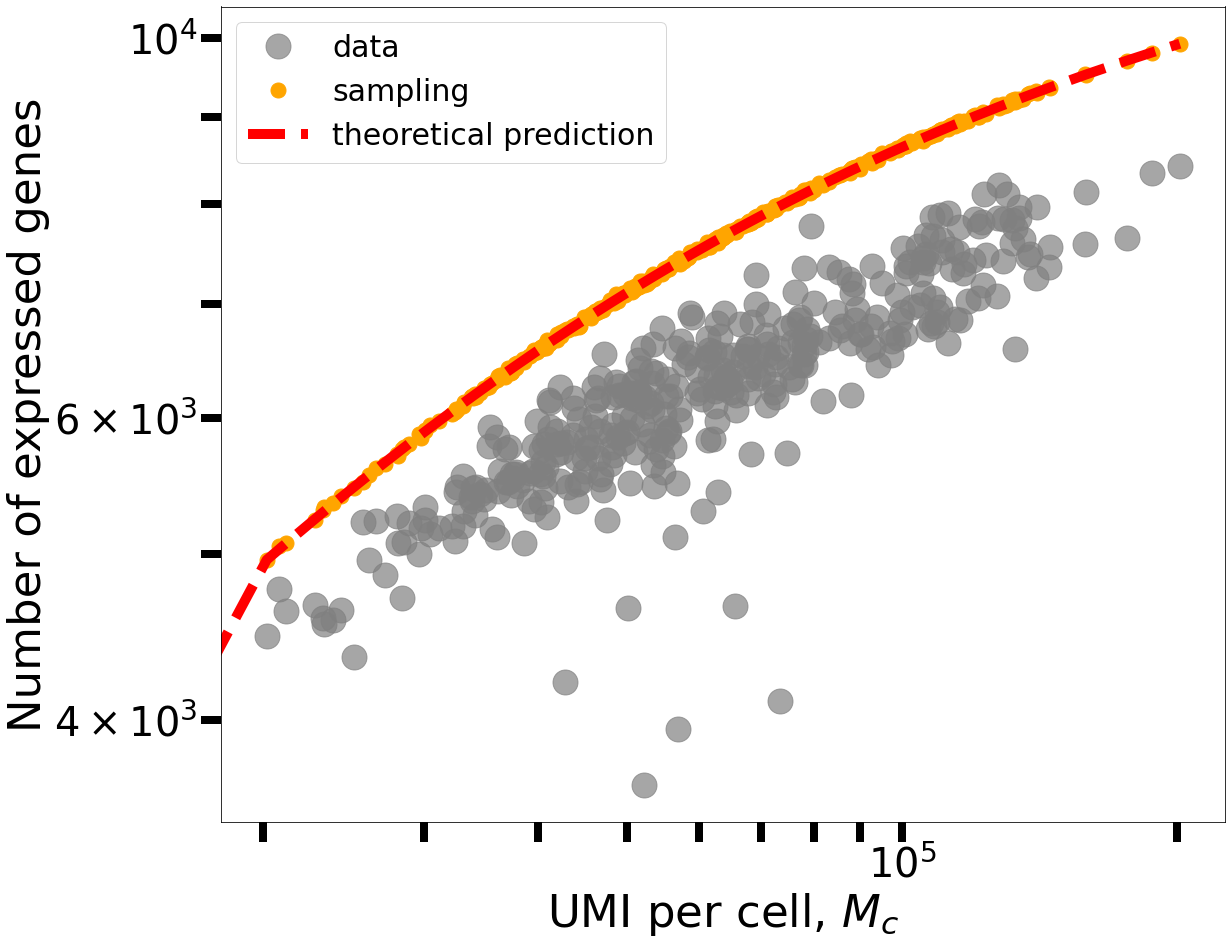

In [37]:
def heaps(data, data_name, save):
    num_genes_expr=(data>0).sum(axis=0)
    h_matrix=np.zeros((data.shape[1],5))
    for i in range(5):
        sampling_data_=sampling_data(data, data_name, save=False)
        h=(sampling_data_>0).sum(axis=0)
        h_matrix[:,i]=h
    sampling_num_genes_expr=h_matrix.mean(axis=1)
    umi=data.sum(axis=0)
    plt.figure(figsize=s_size)
    umi2, num_genes_expr2 = np.sort(np.array(umi)), np.sort(np.array(num_genes_expr))
    # DATA
    plt.plot(umi,num_genes_expr,'o', ms=ms, color='gray',alpha=0.7, label='data')
    # SAMPLING
    plt.plot(umi,sampling_num_genes_expr,'o', ms=15, label='sampling', color='orange')
    # BINNED AVERAGE
    n_bin=12
    bins=np.linspace(umi.min(), umi.max(), num=n_bin)
    binned_y,binned_x=scipy.stats.binned_statistic(umi, num_genes_expr, statistic='mean', bins=bins)[0],scipy.stats.binned_statistic(umi, num_genes_expr, statistic='mean', bins=bins)[1]
    # ANALYTIC PREDICTION
    R = data.shape[1]
    f = 1./R * (data/data.sum(axis=0)).sum(axis=1)
    predicted_genes=np.zeros((R))
    for j in range(R):
        predicted_genes[j]=data.shape[0]-np.sum(1/np.exp(data.sum(axis=0)[j]*f))
    plt.plot(np.sort(umi),predicted_genes[np.argsort(umi)],'--', lw=10, label='theoretical prediction', color='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Number of expressed genes', fontsize=fontsize_written)
    plt.xlabel('UMI per cell, $M_c$', fontsize=fontsize_written)
    plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
    plt.tick_params(which='minor',labelsize=fontsize_ticks, width=8, length=20)
    plt.legend(fontsize=30, loc='upper left')
    if save==True:
        plt.savefig('{}/{}_heaps.pdf'.format(folder_name,data_name),bbox_inches='tight')
heaps(df, data_name,save=False)

# Figs. 8D and S9D
## Occurrences Histogram

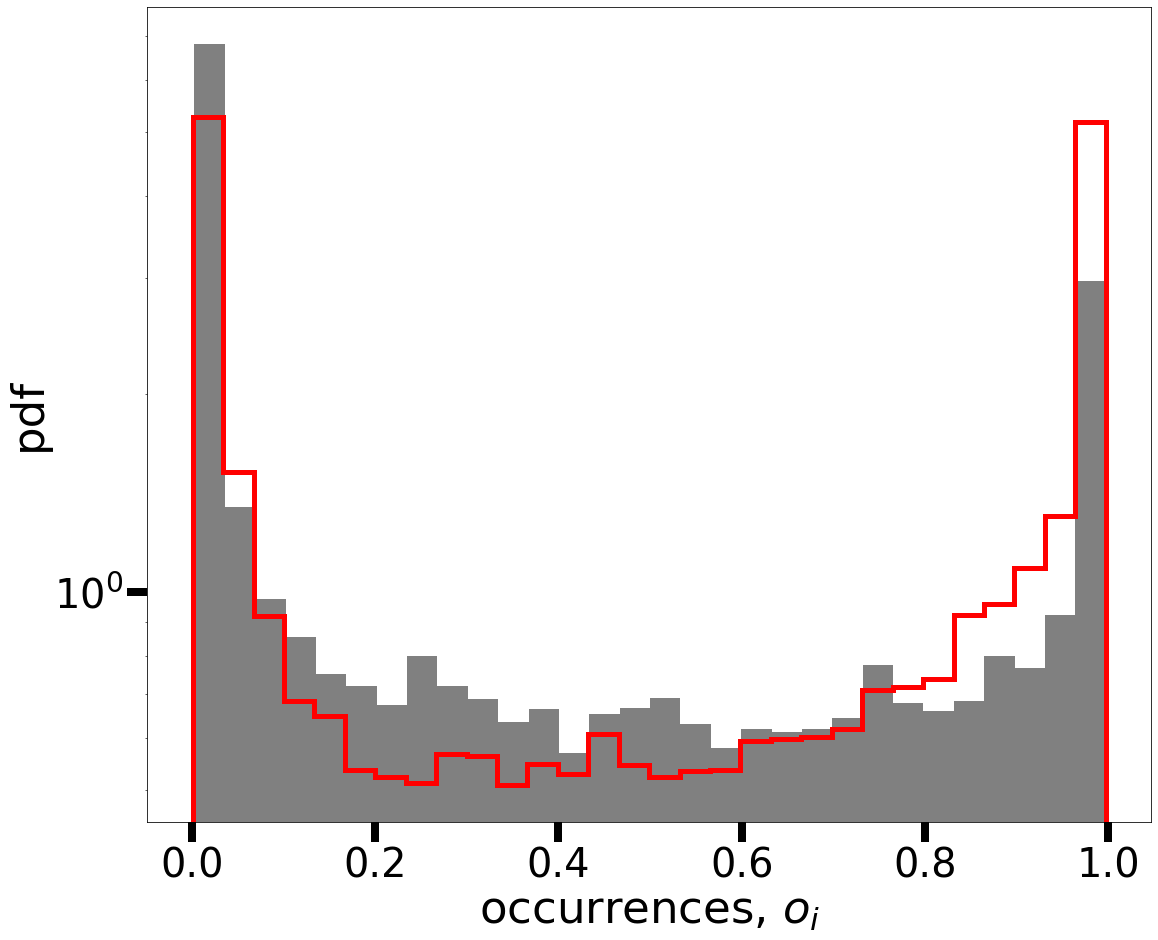

In [38]:
save=False
title='U_{}'.format(data_name)
plt.figure(figsize=s_size)
# DATA
plt.hist(real_occ,bins=30, density=True, color='grey')
# SAMPLING
plt.hist(pred_occ,bins=30, histtype='step',lw=5,color='red',density=True)
plt.yscale('log')
plt.yscale('log')
plt.ylabel('pdf',fontsize=fontsize_written)
plt.xlabel('occurrences, $o_i$',fontsize=fontsize_written)
plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
if save==True:
    plt.savefig('{}/{}.pdf'.format(folder_name,title),bbox_inches='tight')

# Figs. 8E and S9E
## O_i,pred vs. O_i,real

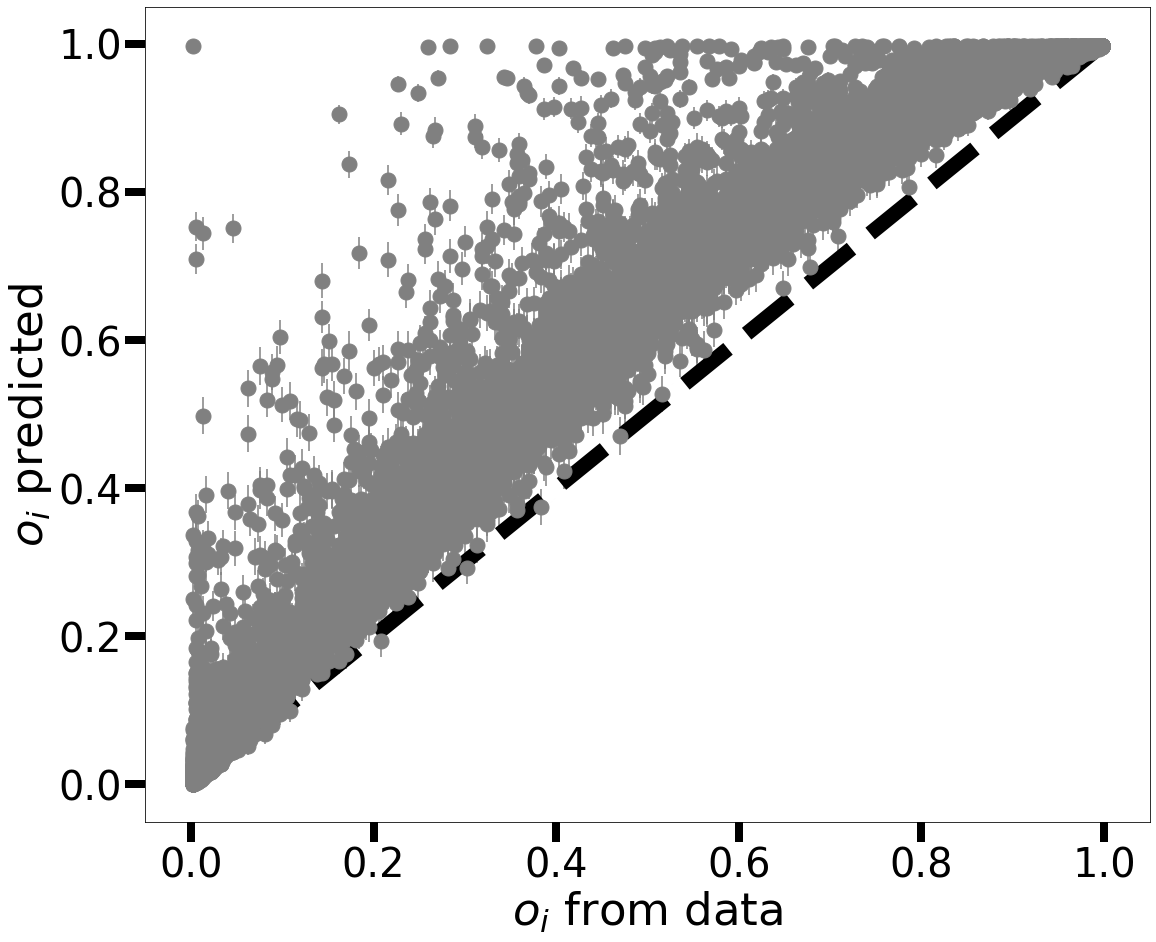

In [40]:
save=False
title='{}_opred_oreal'.format(data_name)
plt.figure(figsize=s_size)
plt.errorbar(df_mainTable['real_occ'],df_mainTable['pred_occ'],yerr=df_mainTable['occ_var'], marker='o',color='grey',ms=15, ls="none")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--',lw=lw, color='black')
plt.ylabel('$o_i$ predicted',fontsize=fontsize_written)
plt.xlabel('$o_i$ from data',fontsize=fontsize_written)
plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
if save==True:
    plt.savefig('{}/{}.pdf'.format(folder_name,title),bbox_inches='tight')

# Figs. 8F and S9F
## o_i,pred - o_i,real Histogram

(14734, 200)


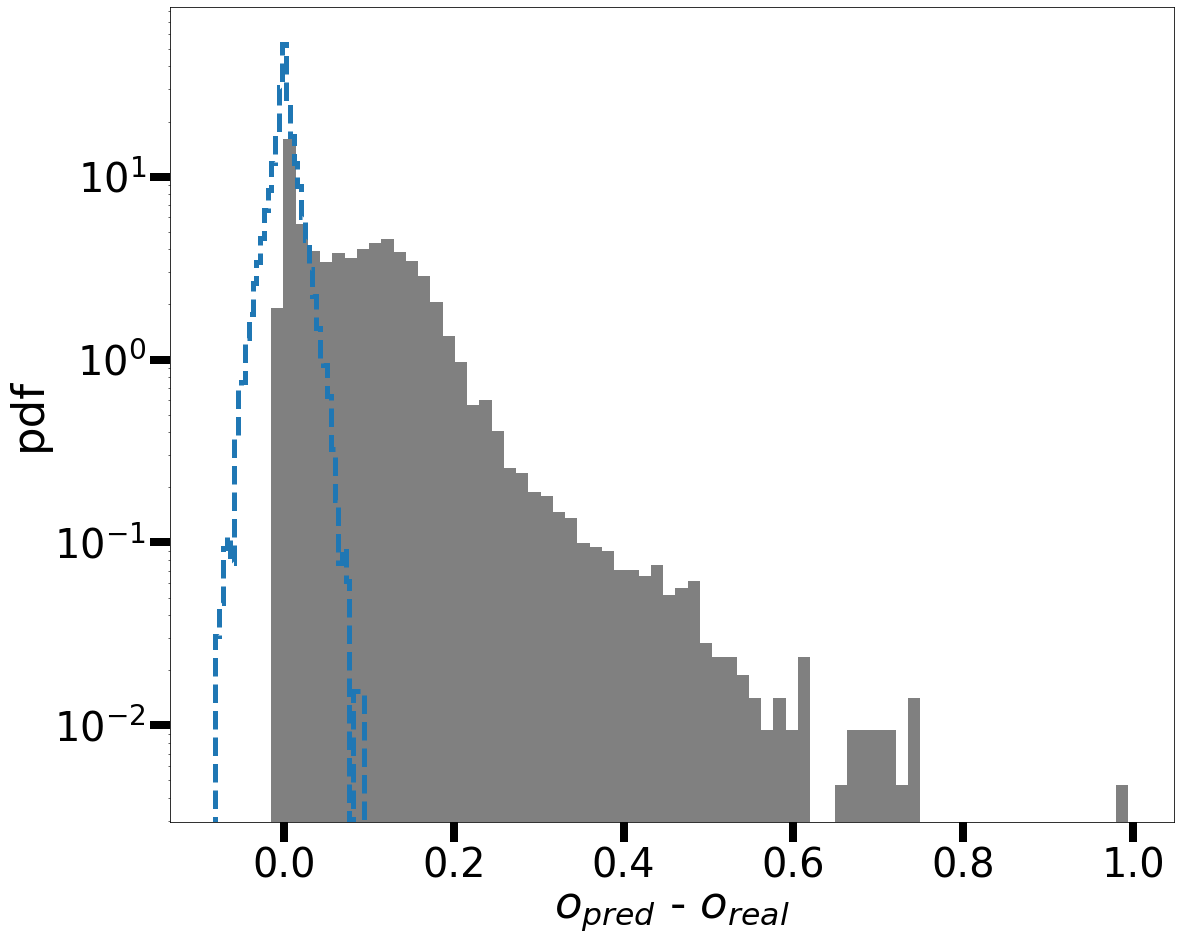

In [59]:
sampling_occ_matrix=notzerossampling_matrix/369
n=sampling_occ_matrix.shape[1]
samp_delta_occ=np.zeros((sampling_occ_matrix.shape[0],sampling_occ_matrix.shape[1]))
print(samp_delta_occ.shape)
#i=np.random.randint(0,200,size=n)
#j=np.random.randint(0,200,size=n)
for i in range(n):
    samp_delta_occ[:,i]=sampling_occ_matrix[:,i]-sampling_occ_matrix.mean(axis=1)

save=False
title='{}_occ_hist'.format(data_name)
occ_diff = opred_oreal

plt.figure(figsize=s_size)
plt.hist(occ_diff, density=True,stacked=True, color='gray',bins=70,rwidth=10)
plt.hist(samp_delta_occ[:,10],density=True,stacked=True, histtype='step',lw=5, ls='--',bins=40,rwidth=10)
plt.yscale('log')
plt.ylabel('pdf',fontsize=fontsize_written)
plt.xlabel('$o_{pred}$ - $o_{real}$',fontsize=fontsize_written)
plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
if save==True:
    plt.savefig('{}/{}.pdf'.format(folder_name,n,title),bbox_inches='tight')

# Figs. 8C and S9C
# $CV^2$ vs. mean

In [44]:
def scatterdense(x, y, ax=None, nbins=80, colorbar=True, c_title="density", **kwargs):
    xmin = np.log10(min(x[x>0]))
    xmax = np.log10(max(x))
    ymin = np.log10(min(y[y>0]))
    ymax = np.log10(max(y))

    xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
    ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
    data , x_e, y_e = np.histogram2d(x, y, bins = (xbins, ybins))
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    if ax is None:
        fig=plt.figure(figsize=s_size)
        ax=fig.subplots()
    ax.scatter(x, y, c=z, s=225, alpha=0.5, cmap="viridis", **kwargs)
    if colorbar:
        from matplotlib import cm
        import matplotlib
        cbar = ax.get_figure().colorbar(cm.ScalarMappable
            (norm=matplotlib.colors.Normalize(vmin=1, vmax=max(z)), cmap="viridis"), ax=ax)
        cbar.ax.set_ylabel(c_title, fontsize=25)
        cbar.ax.tick_params(labelsize=25)

def plotcv2mean(data,means, variances,title, label, ax=None, normalisation_str = "counts", poisson_limit=1, 
                colorbar=True, **kwargs):
    save=False
    if ax is None:
        fig=plt.figure(figsize=(10,7))
        ax=fig.subplots()
        
    #inf_idx_data = np.argwhere(mean.astype(int).values==0)
    #inf_idx_data =inf_idx_data.reshape(inf_idx_data.shape[0])
    means = means[means>0]
    means_idx=np.argwhere(means.values>0)
    means_idx=means_idx.reshape(means_idx.shape[0])
    variances = variances[means_idx]
    
    x_lin = np.logspace(np.log10(np.nanmin(means)),np.log10(np.nanmax(means)), dtype=float,num=50)
    cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
    #plt.figure(figsize=s_size)
    scatterdense(means, cv2,ax=ax, label=label, colorbar=colorbar, c_title="Number of genes", **kwargs)   
    sort_pos=np.sort(means)
    k = np.argwhere(sort_pos>10)[0]
    t=np.linspace(5*10**(-3),10**3,num=1000)
    t2=np.linspace(1,10**4,num=1000)
    p=np.linspace(10**(-2),20,num=1000)
    bound=data.shape[1] -1 
    ax.plot(t,np.repeat(bound,1000),'--',lw=10, color='orange',label='R-1')
    ax.plot(p,1/p,'--',lw=10, color='red',label='$m_g^{-1}}$ (Poisson)')
    #ax.plot(t2,np.repeat(1,1000),'--',lw=10, color='blue',label='1 (Taylor)')
    ax.tick_params(labelsize=20, width=5, length=10, which="major")
    ax.tick_params(labelsize=20, width=5, length=10, which="minor")
    
    ax.set_ylabel("Coefficient of variation squared, $CV^2_g$", fontsize=25)
    ax.set_xlabel("Mean expression level, $m_g$", fontsize=25)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim((5*10**(-3),10**4))
    #ax.set_xlim(means[means>0].min()*0.9,np.power(10,np.log10(np.nanmax(means))+1))
    #ax.legend(fontsize=20)
    if save==True:
        plt.savefig('{}/{}.pdf'.format(folder_name,title),bbox_inches='tight')
    return cv2

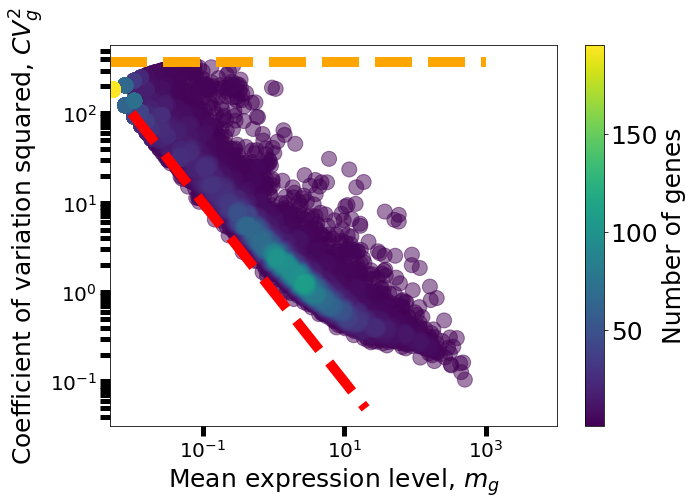

In [46]:
cv2= plotcv2mean(df,df.mean(axis=1), df.var(axis=1),'UMI_coding_CV^2_{}'.format(data_name),'coding_data')